In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

In [2]:
import sys
import os

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation

In [156]:
class NeuralODE(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        # all but last
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        # only the last layer
        x = nn.Dense(self.layer_widths[-1])(x)
        return x
    
def create_train_state(rng, layer_widths, learning_rate):
    # initialize
    model = NeuralODE(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones((2,)))['params']
    tx = optax.adam(learning_rate)
    # return a TrainState object
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    
def loss_fn(params, apply_fn, t, observed_data, y0):
    # func represents the ODE system
    # required to create a callable for odeint
    def func(y, t):
        # apply_fn is function to apply the model
        return apply_fn({'params': params}, y)
    pred_solution = odeint(func, y0, t)
    # odeint will call func(y, t) multiple times
    return jnp.mean(jnp.abs(pred_solution - observed_data))

@jax.jit
def train_step(state, t, observed_data, y0):
    """
    Perform a single training step
    """
    # construct a function that computes both loss and its gradients wrt model parameters
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0)
    
    # update model parameters
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, t, observed_data, y0, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step(state, t, observed_data, y0)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

In [5]:
from data_generation import generate_ode_data

In [43]:
n_points = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 4}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

spacing_type="chebyshev"
t_cheb, y_cheb, y_noisy_cheb, true_derivatives_cheb = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [44]:
print(collocate_data.__doc__)

Applies the kernel-based collocation method to smooth data.

    Args:
        data (jax.numpy.ndarray): The noisy data array.
        tpoints (jax.numpy.ndarray): The array of time points.
        kernel (str, optional): The type of kernel to use ("EpanechnikovKernel" or "TriangularKernel").
        bandwidth (float, optional): The bandwidth for the kernel. If None, it is calculated automatically. Defaults to None.

    Returns:
        tuple: The estimated derivatives and smoothed solutions.
    


In [249]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'TriangularKernel', bandwidth=0.4)

estimated_derivative_cheb, estimated_solution_cheb = collocate_data(y_noisy_cheb, t_cheb, 'TriangularKernel', bandwidth=0.8)

Loss equal: 62.363
Loss Chebyshev: 29.552


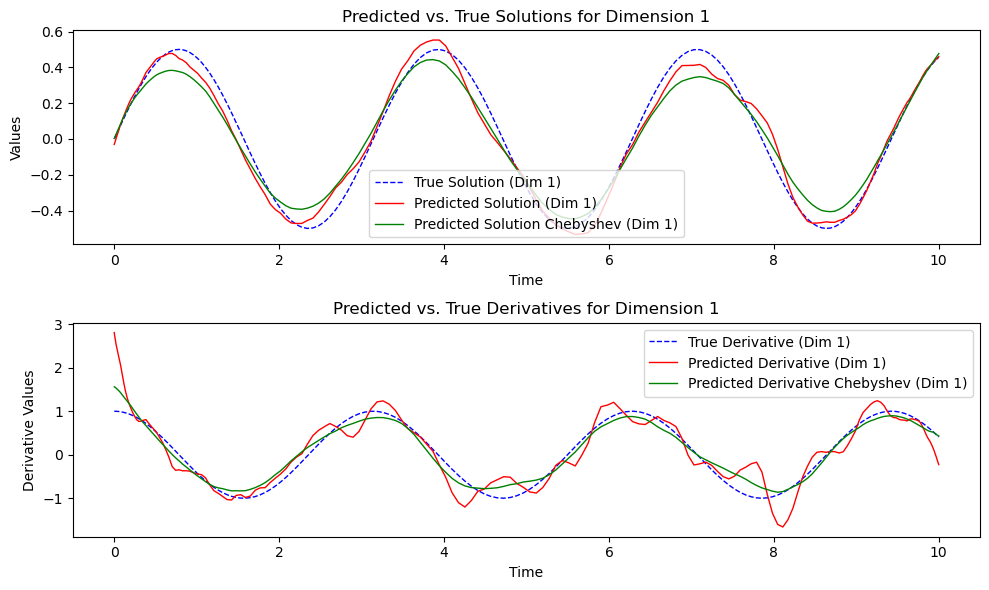

In [250]:
plt.figure(figsize=(10, 6))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 0], 'b--', linewidth=1, label='True Solution (Dim 1)')
plt.plot(t, estimated_solution[0], 'r-', linewidth=1, label='Predicted Solution (Dim 1)')
plt.plot(t_cheb, estimated_solution_cheb[0], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 1')
plt.legend()

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 0], 'b--', linewidth=1, label='True Derivative (Dim 1)')
plt.plot(t, estimated_derivative[0], 'r-', linewidth=1, label='Predicted Derivative (Dim 1)')
plt.plot(t_cheb, estimated_derivative_cheb[0], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1')
plt.legend()

print(f"Loss equal: {jnp.sum(jnp.abs(true_derivatives.T[0] - estimated_derivative[0])):.3f}")
print(f"Loss Chebyshev: {jnp.sum(jnp.abs(true_derivatives_cheb.T[0] - estimated_derivative_cheb[0])):.3f}")

plt.tight_layout() 
plt.show()


Loss equal: 47.990
Loss Chebyshev: 44.381


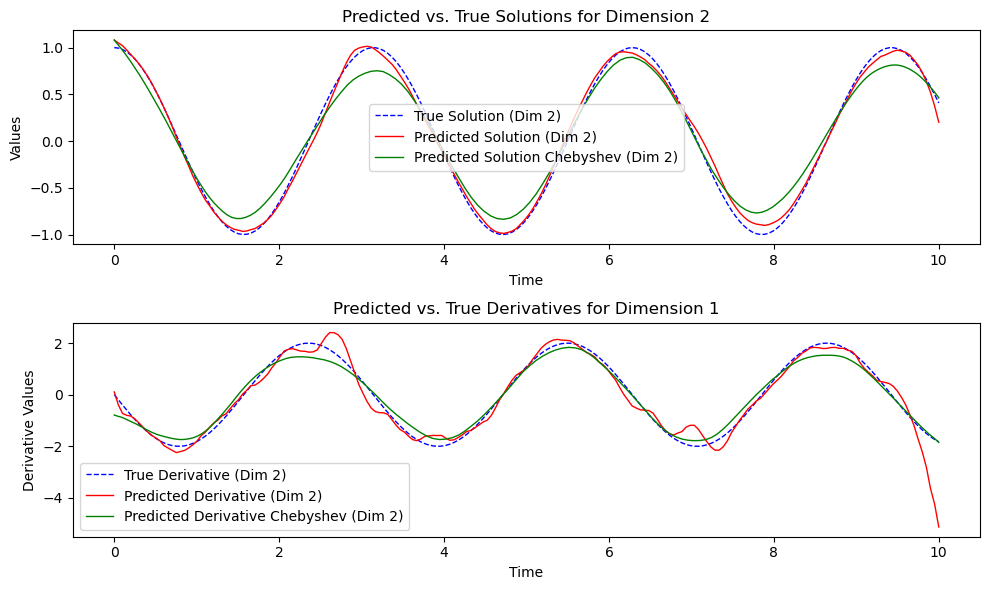

In [47]:
plt.figure(figsize=(10, 6))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 1], 'b--', linewidth=1, label='True Solution (Dim 2)')
plt.plot(t, estimated_solution[1], 'r-', linewidth=1, label='Predicted Solution (Dim 2)')
plt.plot(t_cheb, estimated_solution_cheb[1], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 2)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 2')
plt.legend()

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 1], 'b--', linewidth=1, label='True Derivative (Dim 2)')
plt.plot(t, estimated_derivative[1], 'r-', linewidth=1, label='Predicted Derivative (Dim 2)')
plt.plot(t_cheb, estimated_derivative_cheb[1], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 2)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1')
plt.legend()

print(f"Loss equal: {jnp.sum(jnp.abs(true_derivatives.T[1] - estimated_derivative[1])):.3f}")
print(f"Loss Chebyshev: {jnp.sum(jnp.abs(true_derivatives_cheb.T[1] - estimated_derivative_cheb[1])):.3f}")

plt.tight_layout() 
plt.show()


In [48]:
# Helper function to obtain the solution
def neural_ode(params, y0, t, state):
    def func(y, t):
        return state.apply_fn({'params': params}, y)
    return odeint(func, y0, t)

### Regular Neural ODE

In [157]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

y0 = jnp.array([0.0, 1.0])
state = create_train_state(rng, layer_widths, learning_rate)

In [161]:
state.__dict__.keys()

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state'])

In [163]:
state.__dict__['apply_fn']

<bound method Module.apply of NeuralODE(
    # attributes
    layer_widths = [2, 100, 100, 2]
)>

In [138]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

y0 = jnp.array([0.0, 1.0])
state = create_train_state(rng, layer_widths, learning_rate)
trained_state = train(state, t, y_noisy, y0)

x: (2,)
x: (100,)
x: (100,)
x: (2,)
x: (100,)
x: (100,)
Epoch 0, Loss: 1.6541759967803955
Epoch 100, Loss: 0.48866549134254456
Epoch 200, Loss: 0.4846652150154114
Epoch 300, Loss: 0.47599512338638306
Epoch 400, Loss: 0.48714759945869446
Epoch 500, Loss: 0.4746343493461609
Epoch 600, Loss: 0.44636964797973633
Epoch 700, Loss: 0.3082658648490906
Epoch 800, Loss: 0.16305933892726898
Epoch 900, Loss: 0.16031837463378906


x: (2,)
x: (100,)
x: (100,)


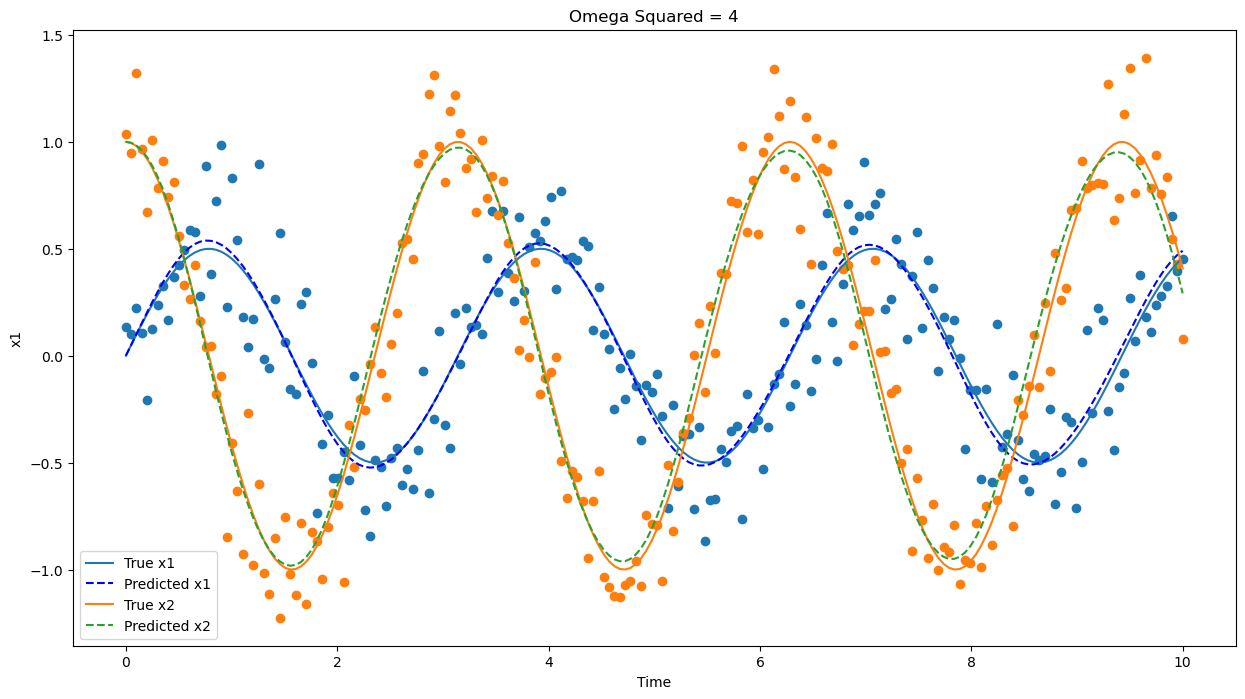

In [187]:
y0 = jnp.array([0.0, 1.0])
y_pred = neural_ode(trained_state.params, y0, t, trained_state)

plt.figure(figsize=(15, 8))
plt.plot(t, y[:, 0], label='True x1')
plt.scatter(t, y_noisy[:, 0])
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.plot(t, y[:, 1], label='True x2')
plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
plt.scatter(t, y_noisy[:, 1])
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()


In [171]:
from jax import jit, value_and_grad
    
class NeuralODE_Collocation(nn.Module):
    layer_widths: list

    @nn.compact
    def __call__(self, x):
        for width in self.layer_widths[:-1]:
            x = nn.Dense(width)(x)
            x = nn.tanh(x)
        x = nn.Dense(self.layer_widths[-1])(x)
        return x
    
    
def create_train_state(rng, layer_widths, input_shape, learning_rate):
    model = NeuralODE_Collocation(layer_widths=layer_widths)
    params = model.init(rng, jnp.ones(input_shape))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


def loss_fn_collocation(params, apply_fn, t, observed_derivative):
    """
    Compute the loss as the mean squared error between predicted derivatives
    and observed derivatives.
    
    Args:
        params (dict): Parameters of the model.
        apply_fn (function): Function to apply the model to input data.
        t (jax.numpy.ndarray): Input features; typically, the time points or other relevant features.
        observed_derivative (jax.numpy.ndarray): True derivatives at the input features.
    
    Returns:
        float: The mean squared error loss.
    """
    # Predict derivatives using the neural network
    print(f"t.shape:{t.shape}")
    pred_derivative = apply_fn({'params': params}, t)

    return jnp.mean(jnp.abs(pred_derivative - observed_derivative))


@jit
def train_step_collocation(state, t, observed_derivative):
    """
    Perform a single training step by computing the loss and its gradients,
    and then updating the model parameters.

    Args:
        state (TrainState object): Contains model state including parameters.
        t (jax.numpy.ndarray): Input features for the model.
        observed_derivative (jax.numpy.ndarray): True derivatives to compare against model predictions.

    Returns:
        tuple: Updated state and loss value.
    """
    def loss_fn(params):
        return loss_fn_collocation(params, state.apply_fn, t, observed_derivative)
    # Construct a function that computes both loss and its gradients wrt model parameters
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

def train_collocation(state, t, observed_data, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step_collocation(state, t, observed_data)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

In [172]:
def loss_fn(params, apply_fn, t, observed_data, y0):
    def func(y, t):
        print(f"y.shape: {y.shape}")
        # apply_fn is function to apply the model
        return apply_fn({'params': params}, y)
    # func represents the ODE system
    pred_solution = odeint(func, y0, t)
    return jnp.mean(jnp.abs(pred_solution - observed_data))

In [177]:
layer_widths = [2, 100, 100, 2]
rng = random.PRNGKey(0)
learning_rate = 1e-3

state_coll = create_train_state(rng, layer_widths, estimated_derivative.shape, learning_rate)

trained_state_collocoation = train_collocation(state_coll, t, estimated_derivative.T)

t.shape:(200,)
Epoch 0, Loss: 1.0849179029464722
Epoch 100, Loss: 0.9955622553825378
Epoch 200, Loss: 0.9955624341964722
Epoch 300, Loss: 0.9955622553825378
Epoch 400, Loss: 0.9955623149871826
Epoch 500, Loss: 0.9955624341964722
Epoch 600, Loss: 0.9955624341964722
Epoch 700, Loss: 0.9956268072128296
Epoch 800, Loss: 0.9955624341964722
Epoch 900, Loss: 0.9955622553825378


In [233]:
y_pred = neural_ode(trained_state.params, y0, t, trained_state_collocoation)

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state'])


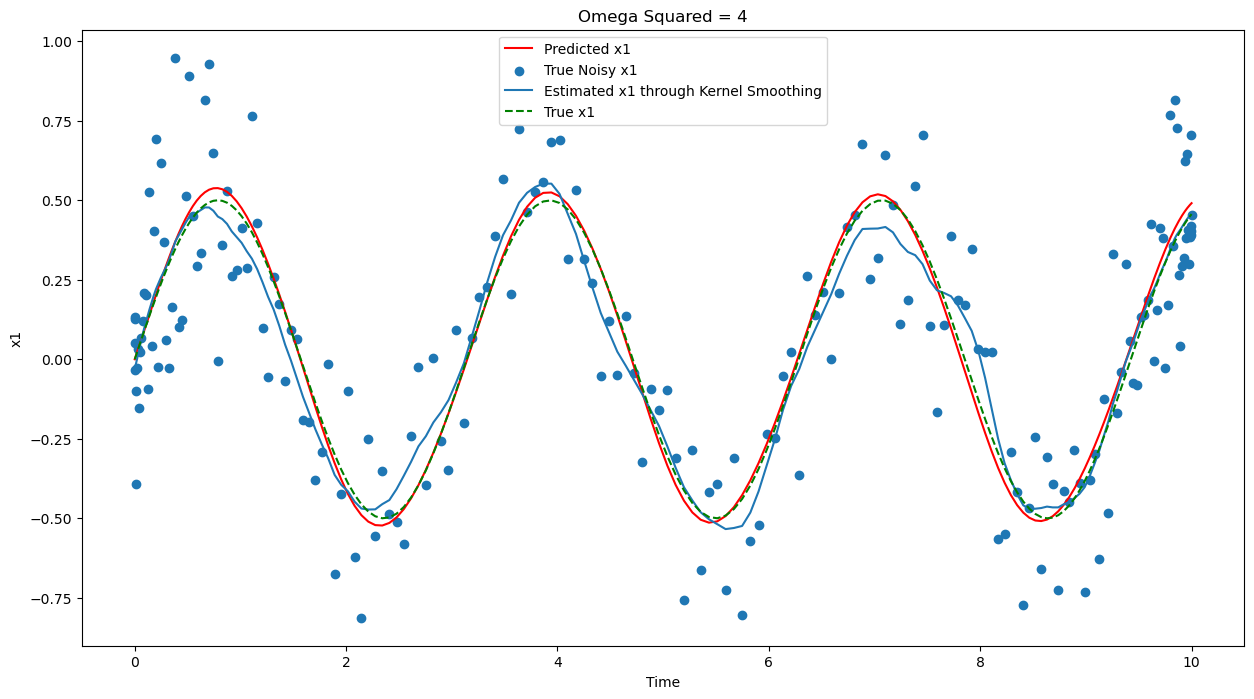

In [252]:
plt.figure(figsize=(15, 8))

plt.plot(t, y_pred.T[0], 'r-', label='Predicted x1')
plt.scatter(t, y_noisy.T[0], label='True Noisy x1')
plt.plot(t, estimated_solution[0], label='Estimated x1 through Kernel Smoothing')
plt.plot(t, y.T[0], 'g--', label='True x1')

plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()

### What about predictions?

In [260]:
end_time = 50 

t_20 = jnp.linspace(0, end_time, 200)
y_pred_20 = neural_ode(trained_state.params, y0, t_20, trained_state_collocoation)

spacing_type = "equally_spaced"
t_20, y_20, y_noisy_20, true_derivatives_20 = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

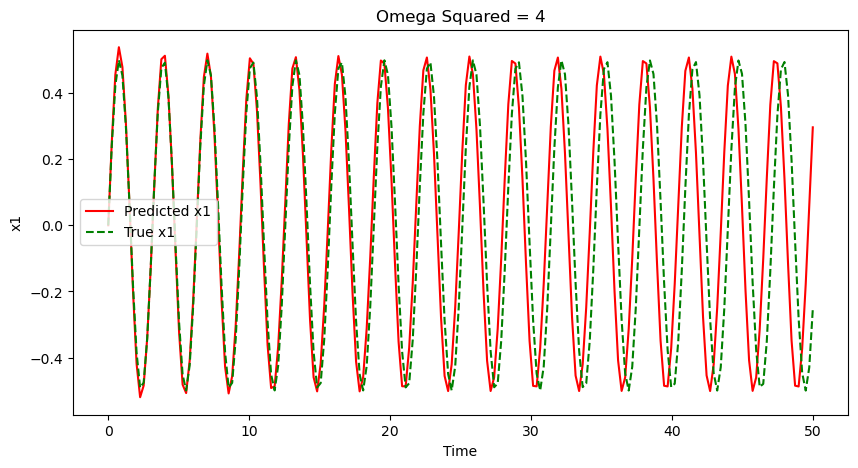

In [261]:
plt.figure(figsize=(10, 5))

plt.plot(t_20, y_pred_20.T[0], 'r-', label='Predicted x1')
plt.plot(t_20, y_20.T[0], 'g--', label='True x1')

plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Omega Squared = {params["omega_squared"]}')
plt.show()